# Machine Learning Foundation Nanodegree 2018-2019
## Project 3: Investigate a Dataset (TMDb Movie Analysis)
### Submission by: Aaron Balson Caroltin .J


### Table of Contents
<ul>
<li><a href="#intro">I. Introduction</a></li>
<li><a href="#wrangling">II. Data Wrangling</a></li>
<li><a href="#eda">III. Exploratory Data Analysis</a></li>
<li><a href="#conclusions">IV. Conclusions</a></li>
</ul>

<a id='intro'></a>
## I. Introduction

What can we say about the success of a movie before it is released? Are there certain companies (Pixar?) that have found a consistent formula? Given that major films costing over $100 million to produce can still flop, this question is more important than ever to the industry. Film aficionados might have different interests. Can we predict which films will be highly rated, whether or not they are a commercial success?

This dataset under investigation is a sub-set / kaggle version of TMDb movies with about 10K movies (rows) and 21 attributes (columns). It is a great place to start digging in to perform exploratory data analysis with data on the plot, cast, crew, budget, and revenues of several thousand films.

<u>Questions we will try answer</u>
1. What are the top 5 movies with the most budget, revenue, profit?
2. Which genres, casts are behind successful movies?
3. How many profitable movies are released on yearly trend?
4. What is the movie runtime strategy for profitable movies?

In [186]:
# All imports

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
% matplotlib inline

<a id='wrangling'></a>
## II. Data Wrangling


### (i) General Properties

In [187]:
# Load Movie data
data = pd.read_csv('tmdb-movies.csv')

def show_dframe_info(data):
    """ Shows Shape, Size, Dim and Structure of data
        Args: data (dataframe) whose info is to be shown
    """
    print('Data Shape (rows, cols):', data.shape)
    print('Data Size (rows x cols):', data.size)
    print('Data Dimensions:', data.ndim)
    print('Data Structure:')
    data.info()
    # Display first 5 rows
    data.head()

show_dframe_info(data)


Data Shape (rows, cols): (10866, 21)
Data Size (rows x cols): 228186
Data Dimensions: 2
Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average 

In [188]:
# Additional observations on numeric columns
def show_range_for_numeric_cols(data):
    """ Shows max, min values of numeric columns
        Args: data (dataframe) whose numeric columns range is shown
    """
    
    print('popularity (min, max) =', data['popularity'].min(), "to" , data['popularity'].max())
    print('vote_count (min, max) =', data['vote_count'].min(), "to" ,data['vote_count'].max())
    print('vote_average (min, max) =', data['vote_average'].min(), "to" ,data['vote_average'].max())
    print('runtime (min, max) =', data['runtime'].min(), "to" ,data['runtime'].max())
    print('revenue (min, max) =', data['revenue'].min(), "to" ,data['revenue'].max())
    
show_range_for_numeric_cols(data)    

popularity (min, max) = 6.500000000000001e-05 to 32.985763
vote_count (min, max) = 10 to 9767
vote_average (min, max) = 1.5 to 9.2
runtime (min, max) = 0 to 900
revenue (min, max) = 0 to 2781505847


In [189]:
# longest runtime
print('Most Runtime:')
data.loc[data['runtime'].idxmax()]


Most Runtime:


id                                                                 125336
imdb_id                                                         tt2044056
popularity                                                       0.006925
budget                                                                  0
revenue                                                                 0
original_title                              The Story of Film: An Odyssey
cast                    Mark Cousins|Jean-Michel Frodon|Cari Beauchamp...
homepage                http://www.channel4.com/programmes/the-story-o...
director                                                     Mark Cousins
tagline                                                               NaN
keywords                cinema|nouvelle vague|hindi cinema|cinema novo...
overview                The Story of Film: An Odyssey, written and dir...
runtime                                                               900
genres                                

In [190]:
#Most popular
print('Most Popular:')
data.loc[data['popularity'].idxmax()]

Most Popular:


id                                                                 135397
imdb_id                                                         tt0369610
popularity                                                        32.9858
budget                                                          150000000
revenue                                                        1513528810
original_title                                             Jurassic World
cast                    Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...
homepage                                    http://www.jurassicworld.com/
director                                                  Colin Trevorrow
tagline                                                 The park is open.
keywords                monster|dna|tyrannosaurus rex|velociraptor|island
overview                Twenty-two years after the events of Jurassic ...
runtime                                                               124
genres                          Action

**Initial Observations**: 
1. All monetary columns are assumed to be of $USD
2. Popularity column (range: 6.5 - 32) is assumed to be of some derived column based on vote_average (range: 0 - 10) and vote_count columns so we will only carry popularity column forward.
3. Film duration (runtime) seems to be in minutes (with an outlier of 900 minutes for British documentary film The Story of Film: An Odyssey which was targeted to TVs than Theatres).
4. Some movies have co-directors, multiple genres, production companies (Piped) but we will assume those combinations to be of seperate and distinct value in those columns (we could have performed one-hot encoding based on questions we seek to answer but we won't be doing it for this analysis)


### (ii) Data Cleaning
Having done the initial observations, we have decided to remove about 11 columns that are inconsequential to answering our questions. We will then find and remove any duplicate records across the remaining columns. We will handle missing values by removing records that have no director information (as we dont have director related questions), however we will replace missing values with "NA" for cast and genre columns. Finally we will also remove records with invalid monetary fields (eg: zero budget and revenue) because our research depends on those columns. We choose <u>not</u> to expand cast or genre columns using getdummies (hot encoding) we will handle those categorical data in code.

In [191]:
# Dropping columns not required for further analysis

def remove_colums(data, cols_to_delete):
    """ Remove columns from dataframe 
        Args: 
            data (dataframe) to operate on
            cols_to_delete (list) names of columns to remove
    """
    print("Cols before removal:", data.shape[1])
    data.drop(cols_to_delete,axis=1, inplace=True)
    # change date columns to datetime
    data.release_date = pd.to_datetime(data['release_date'])
    print("Cols after removal:", data.shape[1])
    
remove_colums(data, ['id', 'imdb_id', 'homepage', 'tagline', 'keywords', 'overview', 'production_companies', 'vote_count', 'vote_average', 'budget_adj', 'revenue_adj'])

Cols before removal: 21
Cols after removal: 10


In [192]:
# Dropping duplicate rows

print("Rows before duplicates removal:", data.shape[0])
data.drop_duplicates(keep ='first', inplace=True)
print("Rows after duplicates removal:", data.shape[0])


Rows before duplicates removal: 10866
Rows after duplicates removal: 10865


In [193]:
# dropna, fillna rows
def handle_missing(data):
    """ Handles missing values by either removing them or replacing them 
        Args: data (dataframe) to operate on
    """
    
    print("Count of null values in each column:")
    print(data.isnull().sum())
    
    print("<p>Rows before null handling:", data.shape[0])
    # Remove rows with "null" director column
    data.dropna(subset=['director'], inplace=True) 
    # Replace "null" with "NA" for cast, genres columns
    data["cast"].fillna("NA", inplace = True) 
    data["genres"].fillna("NA", inplace = True) 
    
    print("Rows after null handling:", data.shape[0])

handle_missing(data)

Count of null values in each column:
popularity         0
budget             0
revenue            0
original_title     0
cast              76
director          44
runtime            0
genres            23
release_date       0
release_year       0
dtype: int64
<p>Rows before null handling: 10865
Rows after null handling: 10821


In [194]:
# remove zero budget & zero revenue movies

def zero_handling(data):
    """ Handles missing values by either removing them or replacing them 
        Args: data (dataframe) to operate on
    """
    print("Rows before zero handling", data.shape[0])
    cond1 = data['budget'] != 0
    cond2 = data['revenue'] != 0
    data_nonzero = data[cond1 & cond2]
    #data.drop(data[cond1 & cond2].index, inplace=True)
    print("Rows after zero handling", data_nonzero.shape[0])

zero_handling(data)
print('Finalized dataset:')
data.head()

Rows before zero handling 10821
Rows after zero handling 3853
Finalized dataset:


,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,release_year
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,2015
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,2015
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2015-03-18,2015
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,2015-12-15,2015
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,2015-04-01,2015


<a id='eda'></a>
## III. Exploratory Data Analysis

### Research Question 1 (What are the top 5 movies with the most budget, revenue & profit?)

In [195]:
# Finding top 5 movies with highest budget
print('Highest budget movies:')
data_nonzero.nlargest(5, 'budget')[['budget', 'original_title', 'release_year']]

Highest budget movies:


,budget,original_title,release_year
2244,425000000,The Warrior's Way,2010
3375,380000000,Pirates of the Caribbean: On Stranger Tides,2011
7387,300000000,Pirates of the Caribbean: At World's End,2007
14,280000000,Avengers: Age of Ultron,2015
6570,270000000,Superman Returns,2006


In [196]:
# Finding top 5 movies with highest revenue
print('Top 5 highest revenue movies:')
data_nonzero.nlargest(5, 'revenue')[['revenue', 'original_title', 'release_year']]

Top 5 highest revenue movies:


,revenue,original_title,release_year
1386,2781505847,Avatar,2009
3,2068178225,Star Wars: The Force Awakens,2015
5231,1845034188,Titanic,1997
4361,1519557910,The Avengers,2012
0,1513528810,Jurassic World,2015


In [197]:
# Finding top 5 movies with highest profit

data_nonzero['profit'] = pd.to_numeric(data_nonzero['revenue'] - data_nonzero['budget'])
#data_nonzero.assign(profit=data_nonzero.revenue - data_nonzero.budget)
#data_nonzero['profit'] = data_nonzero['profit'].astype(int)
#data_nonzero['profit'] = data_nonzero['profit'].apply(lambda x: '{:.2f}'.format(x))
#data_nonzero['profit'] = pd.to_numeric(data_nonzero['profit'])
#data_nonzero['profit'] = data_nonzero['profit'].apply(pd.to_numeric, downcast='float', errors='coerce')

print('Profitable movies:', profit_data['profit'].count())

print('Top 5 highest profitable movies:')
data_nonzero.nlargest(5, 'profit')[['profit', 'original_title', 'release_year']]

#data_nonzero.info()

Profitable movies: 2777
Top 5 highest profitable movies:


,profit,original_title,release_year
1386,2544505847,Avatar,2009
3,1868178225,Star Wars: The Force Awakens,2015
5231,1645034188,Titanic,1997
0,1363528810,Jurassic World,2015
4,1316249360,Furious 7,2015


**Observation:** The top 5 list seems to be in align with the popularity of these movies and hence i will agree on the list.


### Research Question 2  (Which genres, casts are behind successful movies?)

In [198]:
# Helper functions
def get_series_count(df, column, ascend, topn=1):
    """ Get the split based on | and returns entries in the series 
        Args: 
            df(dataframe) to operate on
            column (str) to operate on
            ascend (bool) order by clause
            topn (int) items to return
        Returns: pd series grouped by column name with value counts
    """
    df_temp = df[column].str.cat(sep = '|')
    df_temp = pd.Series(df_temp.split('|'))
    series = df_temp.value_counts(ascending = ascend).head(topn)
    
    return series

def draw_Hbar(s, title):
    """ Draw horizontal bar chart for the series
        Args: 
            s(series) to operate on
            col (str) for labeling
    """
    s.sort_values(ascending = True, inplace = True)
    crt = s.plot.barh(color = '#acdacd', fontsize = 10)

    #title, label, figure size
    title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
    
    crt.set(title = 'Frequency Table')
    crt.set_xlabel('# of successful movies', color = 'black', fontsize = '15')
    crt.set_ylabel('Top ' + title, color = 'black', fontsize = '15')
    crt.figure.set_size_inches(12, 9)
    
    plt.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.legend(['Total'])

    plt.show()

Top 10 successful casts:
Robert De Niro       38
Tom Hanks            33
Bruce Willis         33
Tom Cruise           31
Brad Pitt            30
Samuel L. Jackson    30
Denzel Washington    29
Harrison Ford        28
Morgan Freeman       28
Johnny Depp          27
dtype: int64


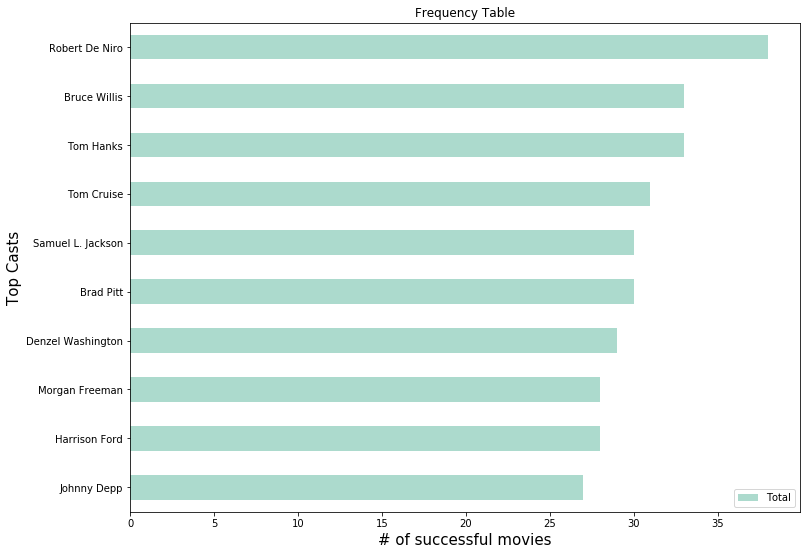

In [199]:
# Get top 10 casts from successful movies (profit > 0)
profit_data = data_nonzero[data_nonzero['profit'] > 0]
casts = get_series_count(profit_data, 'cast', ascend=False, topn=10)

print('Top 10 successful casts:')
print(casts)

draw_Hbar(casts, 'Casts')

Top 10 successful genres:
Drama              1171
Comedy             1009
Thriller            839
Action              788
Adventure           575
Romance             473
Crime               465
Science Fiction     382
Horror              343
Family              340
dtype: int64


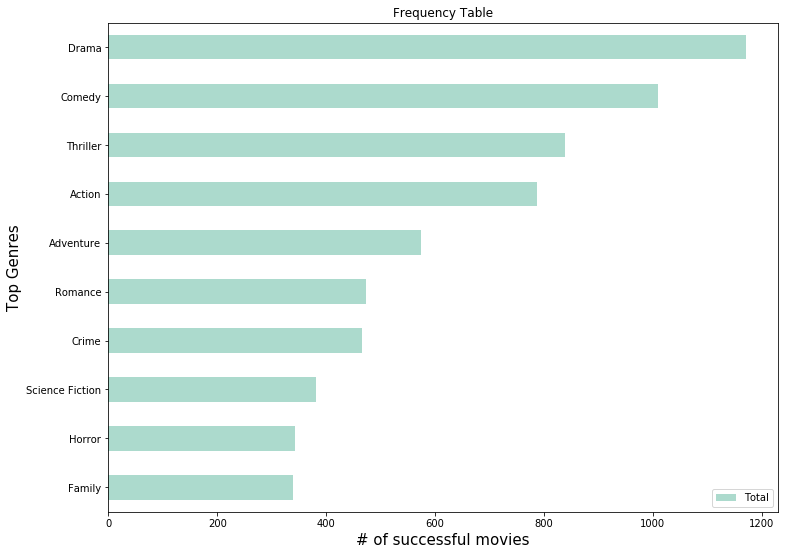

In [200]:
#get top 10 genres from successful movies (profit > 0)
profit_data = data_nonzero[data_nonzero['profit'] > 0]
genres = get_series_count(profit_data, 'genres', ascend=False, topn=10)

print('Top 10 successful genres:')
print(genres)

draw_Hbar(genres, 'Genres')


**Observation:** I can agree on the top 5 genres however the database is more inclined towards hollywood / english viewers and hence the culture, age of viewers have to be taken into account.

### Research Question 3  (How many profitable movies are released on yearly trend?)

In [201]:
# Find total yearly profit from all profitted movies and based on release_year
total_yearly_profit = profit_data.groupby('release_year')['profit'].sum()
#print(total_yearly_profit)
total_yearly_profit.describe()


count    5.600000e+01
mean     5.121541e+09
std      5.554346e+09
min      5.246869e+07
25%      6.496452e+08
50%      2.281079e+09
75%      8.892808e+09
max      1.944833e+10
Name: profit, dtype: float64

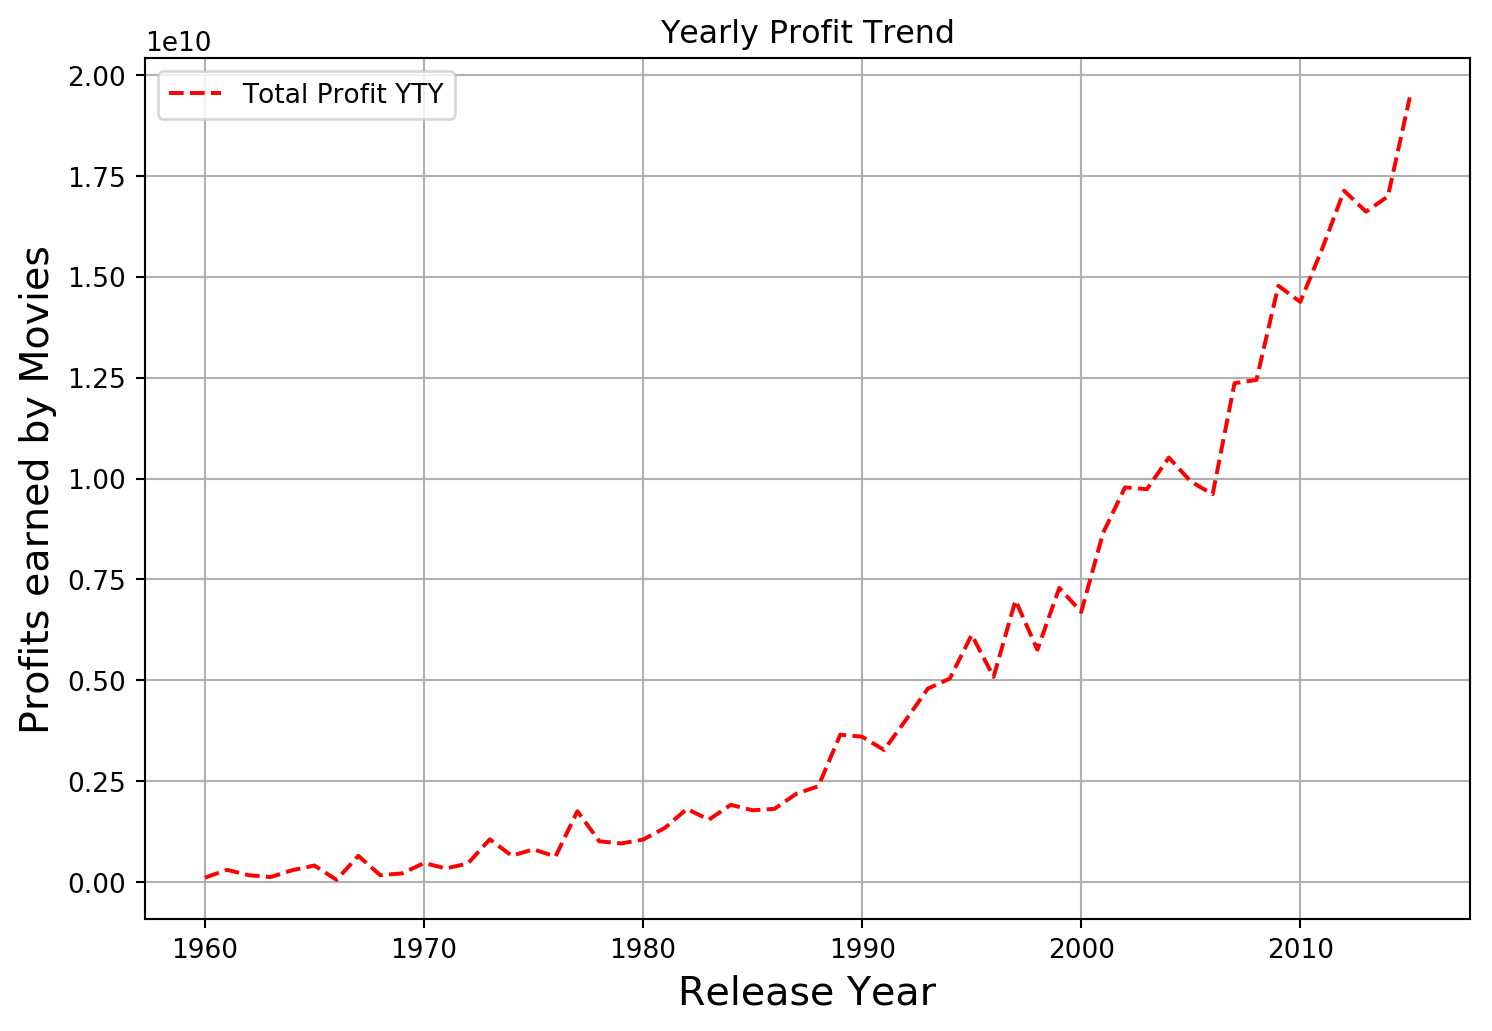

In [202]:
# plot line graph to describe the trend
plt.figure(figsize=(9,6), dpi = 190)

#set axis, labels, title
plt.xlabel('Release Year', fontsize = 15)
plt.ylabel('Profits earned by Movies', fontsize = 15)
plt.title('Yearly Profit Trend')
plt.grid(True)


plt.plot(total_yearly_profit, 'r--')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.legend(['Total Profit YTY'])
plt.show()

**Observation:** based on single-variable (1d) and multiple-variable (2d) explorations, the reason we are seeing an upward trend for # of successful movies released can be attributed to the increased professionalism in the highly competitive movie making field. Technology also plays major role in making a movie hit. Viewership has increased since the age of internet as well.

### Research Question 4  (What is the movie runtime strategy for profitable movies?)

In [203]:
# describe the runtime (minutes)

profit_data['runtime'].describe()

count    2777.000000
mean      110.159165
std        20.113490
min        26.000000
25%        96.000000
50%       106.000000
75%       121.000000
max       248.000000
Name: runtime, dtype: float64

Text(0.5,1,'Successful movie runtime released before 1980')

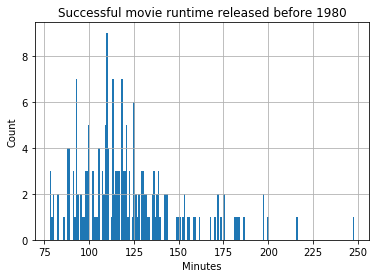

In [204]:
# Movie runtime for profitable movies
profit_data['runtime'][profit_data['release_year'] < 1980].hist(bins=200);
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.title('Successful movie runtime released before 1980')

Text(0.5,1,'Successful movie runtime released after 1980')

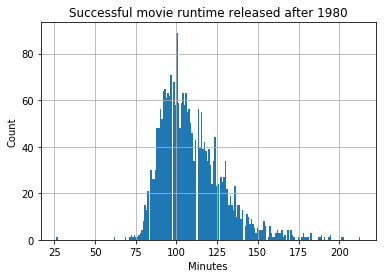

In [205]:
profit_data['runtime'][profit_data['release_year'] >= 1980].hist(bins=200);
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.title('Successful movie runtime released after 1980')

**Observation:** based on single-variable (1d) and multiple-variable (2d) explorations, the sweet spot seems to be around 90-110 minutes mark (mean = 110.159165).<br/>
Irrespective of older or newer movies, people wish to get entertained for about the same time (boredom threshold)


<a id='conclusions'></a>
## IV. Conclusions

It is found that for a movie to be hit, it is likely to be around 110 minutes long, be in any one of these genres (Drama, Comedy, Thriller, Action, Adventure). Ofcourse, it needs the correct timing of the public, reviews, seasonal mood as well the cast & crew performance to make it a hit. Only 2777 movies were profitable but it could be attributed to lack of accurate budget or revenue data out of 3843 datapoints we started with (having non-zero budget, revenue). 

Limitations:
1. We started with 10K records but reduced to about 3.5K records after our data cleaning process, particularly after removing the monetary columns with zero values. We had to settle for non zero values only because of the financial questions we set to find out, there by reducing or may be even skewing the results for non-financial questions (like popular genre or cast).
2. Also we are unaware of how the popularity was derived as different audience can provide different ratings yet, only same type of audience usually get to vote mostly (internet savvy and/or young) so it can skew such datasets collected via online. So i completely taken out rating/popularity based questions merely based on them.

**References:**

https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-39e811c81a0c<br/>
https://pandas.pydata.org/pandas-docs<br/>
https://seaborn.pydata.org/tutorial/categorical.html<br/>
https://udacity-reviews-uploads.s3.us-west-2.amazonaws.com/_attachments/33591/1530440836/new_chart.jpeg<br/>
https://matplotlib.org/gallery/index.html<br/>
http://pandas.pydata.org/pandas-docs/stable/groupby.html<br/>
https://chrisalbon.com/python/data_wrangling/pandas_dataframe_count_values/<br/>
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html<br/>
https://matplotlib.org/users/pyplot_tutorial.html<br/>
